In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import scipy.stats as stats
sns.set_theme()
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.fixes import loguniform
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore")

In [2]:
churn=pd.read_csv('churn.csv')
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


<AxesSubplot:ylabel='Churn'>

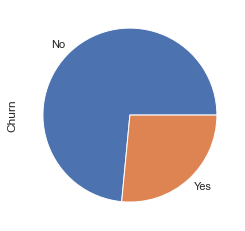

In [3]:
churn.Churn.value_counts().plot.pie()

In [4]:
churn.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,5986.000000,5986.000000,5986.000000
mean,0.161377,32.468760,64.802213
std,0.367909,24.516391,30.114702
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.650000
50%,0.000000,29.000000,70.400000
75%,0.000000,56.000000,89.900000
max,1.000000,72.000000,118.750000


In [5]:
churn.isna().any(axis=1).sum() / len(churn)

0.0

In [6]:
churn.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5986 non-null   object 
 1   gender            5986 non-null   object 
 2   SeniorCitizen     5986 non-null   int64  
 3   Partner           5986 non-null   object 
 4   Dependents        5986 non-null   object 
 5   tenure            5986 non-null   int64  
 6   PhoneService      5986 non-null   object 
 7   MultipleLines     5986 non-null   object 
 8   InternetService   5986 non-null   object 
 9   OnlineSecurity    5986 non-null   object 
 10  OnlineBackup      5986 non-null   object 
 11  DeviceProtection  5986 non-null   object 
 12  TechSupport       5986 non-null   object 
 13  StreamingTV       5986 non-null   object 
 14  StreamingMovies   5986 non-null   object 
 15  Contract          5986 non-null   object 
 16  PaperlessBilling  5986 non-null   object 


In [8]:
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

In [9]:
def prepa_data(churn):
	myChurn=churn
	myChurn['TotalCharges'] = pd.to_numeric(myChurn.TotalCharges, errors='coerce')
	myChurn.dropna(subset = ["TotalCharges"], inplace=True)
	myChurn = pd.get_dummies(myChurn,columns=['gender','SeniorCitizen','Partner','Dependents','InternetService',
       'DeviceProtection', 
       'StreamingTV',
       'Contract','PhoneService',
        'MultipleLines','OnlineSecurity','OnlineBackup','TechSupport','StreamingMovies',
       'PaymentMethod','PaperlessBilling'],drop_first=True)
	myData=myChurn.drop(columns=['customerID'])
	X = myData.drop(columns = ['Churn'])
	y = myData['Churn'].values
	return X,y

In [10]:
X,y = prepa_data(churn)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify =y)

In [12]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

In [13]:

clf = SGDClassifier(loss="hinge", penalty="elasticnet", fit_intercept=True)

param_dist = {
    "average": [True, False],
    "l1_ratio": stats.uniform(0, 1),
    "alpha": loguniform(1e-2, 1e0),
}

# run randomized search
n_iter_search = 15
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=n_iter_search
)

start = time()
random_search.fit(X_train, y_train)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search.cv_results_)

RandomizedSearchCV took 4.60 seconds for 15 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.775 (std: 0.008)
Parameters: {'alpha': 0.01678211068197558, 'average': False, 'l1_ratio': 0.6487524368895472}

Model with rank: 2
Mean validation score: 0.764 (std: 0.010)
Parameters: {'alpha': 0.9600069987533852, 'average': False, 'l1_ratio': 0.82044063022099}

Model with rank: 3
Mean validation score: 0.758 (std: 0.006)
Parameters: {'alpha': 0.043785738584927104, 'average': True, 'l1_ratio': 0.9610342638678266}



In [14]:
# use a full grid over all parameters
param_grid = {
    "average": [True, False],
    "l1_ratio": np.linspace(0, 1, num=10),
    "alpha": np.power(10, np.arange(-2, 1, dtype=float)),
}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search.cv_results_["params"]))
)
report(grid_search.cv_results_)

GridSearchCV took 14.76 seconds for 60 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.788 (std: 0.008)
Parameters: {'alpha': 0.01, 'average': False, 'l1_ratio': 1.0}

Model with rank: 2
Mean validation score: 0.782 (std: 0.007)
Parameters: {'alpha': 0.01, 'average': False, 'l1_ratio': 0.1111111111111111}

Model with rank: 3
Mean validation score: 0.780 (std: 0.010)
Parameters: {'alpha': 0.01, 'average': False, 'l1_ratio': 0.4444444444444444}



In [15]:
# modèle 1 _ SGD Classifier optimized
clf1_optimized = clf = SGDClassifier(loss="hinge", penalty="elasticnet", fit_intercept=True, alpha = 0.3292945376179236, average = False, l1_ratio = 0.8537735034401092)
clf1_optimized.fit(X_train, y_train)
y_pred = clf1_optimized.predict(X_test)
#pd.crosstab(y_test, y_pred)
b= confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None)
print(b)
c= classification_report(y_test, y_pred)
print(c)

[[1377   72]
 [ 367  157]]
              precision    recall  f1-score   support

          No       0.79      0.95      0.86      1449
         Yes       0.69      0.30      0.42       524

    accuracy                           0.78      1973
   macro avg       0.74      0.62      0.64      1973
weighted avg       0.76      0.78      0.74      1973



In [16]:
pickle.dump(clf1_optimized, open('SGD_model_2.pkl','wb'))

In [17]:
clf2 = DecisionTreeClassifier()


param_dist2 = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
               'splitter': ['best', 'random']}

# run randomized search
n_iter_search = 15
random_search2 = RandomizedSearchCV(
    clf2, param_distributions=param_dist2, n_iter=n_iter_search
)

start = time()
random_search2.fit(X_train, y_train)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search2.cv_results_)

RandomizedSearchCV took 1.50 seconds for 15 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.778 (std: 0.012)
Parameters: {'splitter': 'random', 'max_depth': 8, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 0.773 (std: 0.017)
Parameters: {'splitter': 'random', 'max_depth': 8, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.737 (std: 0.012)
Parameters: {'splitter': 'best', 'max_depth': 12, 'criterion': 'entropy'}



In [18]:
# use a full grid over all parameters

param_grid2 = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
               'splitter': ['best', 'random']}

# run grid search
grid_search2 = GridSearchCV(clf2, param_grid=param_grid2)
start = time()
grid_search2.fit(X_train, y_train)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search2.cv_results_["params"]))
)
report(grid_search2.cv_results_)

GridSearchCV took 6.03 seconds for 72 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.786 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}

Model with rank: 2
Mean validation score: 0.783 (std: 0.014)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'splitter': 'best'}

Model with rank: 3
Mean validation score: 0.783 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': 4, 'splitter': 'best'}



In [19]:
# modèle 2 _ DTC Classifier optimized
clf2_optimized = DecisionTreeClassifier(splitter= 'random', max_depth = 8, criterion = 'entropy')
clf2_optimized.fit(X_train, y_train)
y_pred2 = clf2_optimized.predict(X_test)
#pd.crosstab(y_test, y_pred)
b2= confusion_matrix(y_test, y_pred2, labels=None, sample_weight=None, normalize=None)
print(b2)
c2= classification_report(y_test, y_pred2)
print(c2)

[[1272  177]
 [ 266  258]]
              precision    recall  f1-score   support

          No       0.83      0.88      0.85      1449
         Yes       0.59      0.49      0.54       524

    accuracy                           0.78      1973
   macro avg       0.71      0.69      0.69      1973
weighted avg       0.76      0.78      0.77      1973



In [20]:
pickle.dump(clf2_optimized, open('DTC_model_2.pkl','wb'))

In [21]:
clf3 = LogisticRegression()


param_dist3 = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
               'C': [.001,.01,.1,1],
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga’']
               }

# run randomized search
n_iter_search = 15
random_search3 = RandomizedSearchCV(
    clf3, param_distributions=param_dist3, n_iter=n_iter_search
)

start = time()
random_search3.fit(X_train, y_train)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search3.cv_results_)

RandomizedSearchCV took 3.58 seconds for 15 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.801 (std: 0.014)
Parameters: {'solver': 'newton-cg', 'penalty': 'none', 'C': 0.01}

Model with rank: 2
Mean validation score: 0.792 (std: 0.004)
Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.001}

Model with rank: 3
Mean validation score: 0.770 (std: 0.014)
Parameters: {'solver': 'sag', 'penalty': 'none', 'C': 1}



In [22]:
# use a full grid over all parameters

param_grid3 = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
               'C': [.001,.01,.1,1],
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga’']
               }

# run grid search
grid_search3 = GridSearchCV(clf3, param_grid=param_grid3)
start = time()
grid_search3.fit(X_train, y_train)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search3.cv_results_["params"]))
)
report(grid_search3.cv_results_)

GridSearchCV took 20.01 seconds for 80 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.803 (std: 0.012)
Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

Model with rank: 2
Mean validation score: 0.802 (std: 0.014)
Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Model with rank: 3
Mean validation score: 0.801 (std: 0.009)
Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}



In [23]:
# modèle 3 _ LOGISTIC REGRESSION Classifier optimized
clf3_optimized = LogisticRegression(solver ='liblinear', penalty = 'l2', C = .1)
clf3_optimized.fit(X_train, y_train)
y_pred3 = clf3_optimized.predict(X_test)
#pd.crosstab(y_test, y_pred)
b3= confusion_matrix(y_test, y_pred3, labels=None, sample_weight=None, normalize=None)
print(b3)
c3= classification_report(y_test, y_pred3)
print(c3)

[[1308  141]
 [ 251  273]]
              precision    recall  f1-score   support

          No       0.84      0.90      0.87      1449
         Yes       0.66      0.52      0.58       524

    accuracy                           0.80      1973
   macro avg       0.75      0.71      0.73      1973
weighted avg       0.79      0.80      0.79      1973



In [24]:
pickle.dump(clf3_optimized, open('LOGIT_model_2.pkl','wb'))

In [25]:
clf4 = GradientBoostingClassifier()


param_dist4 = {'n_estimators':[5,50,250,500],
               'max_depth':[1,3,5,7,9],
               'learning_rate':[0.01,0.1,1,10,100]
               }

# run randomized search
n_iter_search = 15
random_search4 = RandomizedSearchCV(
    clf4, param_distributions=param_dist4, n_iter=n_iter_search
)

start = time()
random_search4.fit(X_train, y_train)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search4.cv_results_)

RandomizedSearchCV took 92.29 seconds for 15 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.801 (std: 0.007)
Parameters: {'n_estimators': 50, 'max_depth': 1, 'learning_rate': 1}

Model with rank: 2
Mean validation score: 0.800 (std: 0.005)
Parameters: {'n_estimators': 250, 'max_depth': 1, 'learning_rate': 0.1}

Model with rank: 3
Mean validation score: 0.791 (std: 0.008)
Parameters: {'n_estimators': 50, 'max_depth': 1, 'learning_rate': 0.1}



In [26]:
# use a full grid over all parameters

param_grid4 = {'n_estimators':[5,50,250,500],
               'max_depth':[1,3,5,7,9],
               'learning_rate':[0.01,0.1,1,10,100]
               }


# run grid search
grid_search4 = GridSearchCV(clf4, param_grid=param_grid4)
start = time()
grid_search4.fit(X_train, y_train)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search4.cv_results_["params"]))
)
report(grid_search4.cv_results_)

GridSearchCV took 840.38 seconds for 100 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.801 (std: 0.007)
Parameters: {'learning_rate': 1, 'max_depth': 1, 'n_estimators': 50}

Model with rank: 2
Mean validation score: 0.800 (std: 0.005)
Parameters: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 250}

Model with rank: 3
Mean validation score: 0.800 (std: 0.003)
Parameters: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500}



In [27]:
# modèle 4 _ GRADIENT BOOSTING Classifier optimized
clf4_optimized = GradientBoostingClassifier(learning_rate=.1, max_depth= 3, n_estimators= 50)
clf4_optimized.fit(X_train, y_train)
y_pred4 = clf4_optimized.predict(X_test)
#pd.crosstab(y_test, y_pred)
b4= confusion_matrix(y_test, y_pred4, labels=None, sample_weight=None, normalize=None)
print(b4)
c4= classification_report(y_test, y_pred4)
print(c4)

[[1339  110]
 [ 287  237]]
              precision    recall  f1-score   support

          No       0.82      0.92      0.87      1449
         Yes       0.68      0.45      0.54       524

    accuracy                           0.80      1973
   macro avg       0.75      0.69      0.71      1973
weighted avg       0.79      0.80      0.78      1973



In [28]:
pickle.dump(clf4_optimized, open('GBOOST_model_2.pkl','wb'))

In [29]:
clf5 =  GaussianNB()

#https://medium.com/analytics-vidhya/how-to-improve-naive-bayes-9fa698e14cba
param_dist5 = {
    'var_smoothing': np.logspace(0,-9, num=100)
}           

# run randomized search
n_iter_search = 15
random_search5 = RandomizedSearchCV(
    clf5, param_distributions=param_dist5, n_iter=n_iter_search
)

start = time()
random_search5.fit(X_train, y_train)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search5.cv_results_)

RandomizedSearchCV took 0.65 seconds for 15 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.767 (std: 0.004)
Parameters: {'var_smoothing': 1.2328467394420658e-05}

Model with rank: 2
Mean validation score: 0.765 (std: 0.008)
Parameters: {'var_smoothing': 1.5199110829529332e-05}

Model with rank: 3
Mean validation score: 0.764 (std: 0.006)
Parameters: {'var_smoothing': 8.111308307896873e-06}



In [30]:
# use a full grid over all parameters

param_grid5 = {'var_smoothing': np.logspace(0,-9, num=100)
               }

# run grid search
grid_search5 = GridSearchCV(clf5, param_grid=param_grid5)
start = time()
grid_search5.fit(X_train, y_train)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search5.cv_results_["params"]))
)
report(grid_search5.cv_results_)

GridSearchCV took 5.65 seconds for 100 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.790 (std: 0.008)
Parameters: {'var_smoothing': 0.0001}

Model with rank: 2
Mean validation score: 0.787 (std: 0.006)
Parameters: {'var_smoothing': 8.111308307896872e-05}

Model with rank: 3
Mean validation score: 0.786 (std: 0.009)
Parameters: {'var_smoothing': 0.0001232846739442066}



In [31]:
# modèle 5 _ NAIVE BAYE Classifier optimized
clf5_optimized = GaussianNB(var_smoothing= .0001)
clf5_optimized.fit(X_train, y_train)
y_pred5 = clf5_optimized.predict(X_test)
#pd.crosstab(y_test, y_pred)
b5= confusion_matrix(y_test, y_pred5, labels=None, sample_weight=None, normalize=None)
print(b5)
c5= classification_report(y_test, y_pred5)
print(c5)

[[1367   82]
 [ 355  169]]
              precision    recall  f1-score   support

          No       0.79      0.94      0.86      1449
         Yes       0.67      0.32      0.44       524

    accuracy                           0.78      1973
   macro avg       0.73      0.63      0.65      1973
weighted avg       0.76      0.78      0.75      1973



In [32]:
pickle.dump(clf5_optimized, open('GAUSSIANNB_model_2.pkl','wb'))